In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools
from os import path
import matplotlib.ticker as ticker
from scipy import stats
from sklearn.linear_model import LinearRegression

labels = ["paiceHusk", "krovetz", "sStripping", "porter2", "lovins", "wikt", "none"]
collection_n_values = [1,2,4,8,16,32,64]
collection_sizes = [52342886, 26171443, 13085721, 6542860, 3271430, 1635715, 817857]

home_dir = "/home/katelyn/Documents/COSC490/Stemming"
data_dir_clueweb = path.join(home_dir, "Data/clueweb")
data_dir_wikt = path.join(home_dir, "Data/wikt")

MARKERS = ["o","^","s","*","d", "P", "X"]

### Preparing Data

In [6]:
df_list = list()

for n in collection_n_values:
   df = pd.read_csv(path.join(data_dir_clueweb,f"collectionSize/ndcg_{n}"), sep=" ")
   df_list.append(df)

data = pd.concat(df_list, ignore_index=True)

data_avg = data[data["qid"] == "amean"]
data = data.drop(data[data["qid"] == "amean"].index)


### Overall nDCG

In [7]:
best_nDCG = list()
for size in collection_sizes:
    selected_data = data_avg[data_avg["collectionSize"] == size]
    best_nDCG.append(selected_data["ndcg"].max())

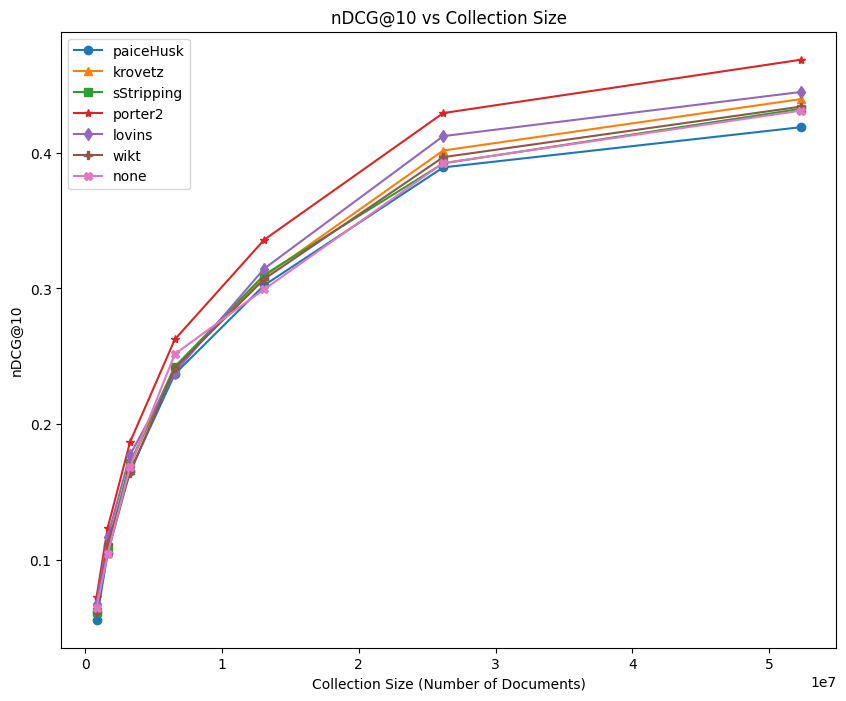

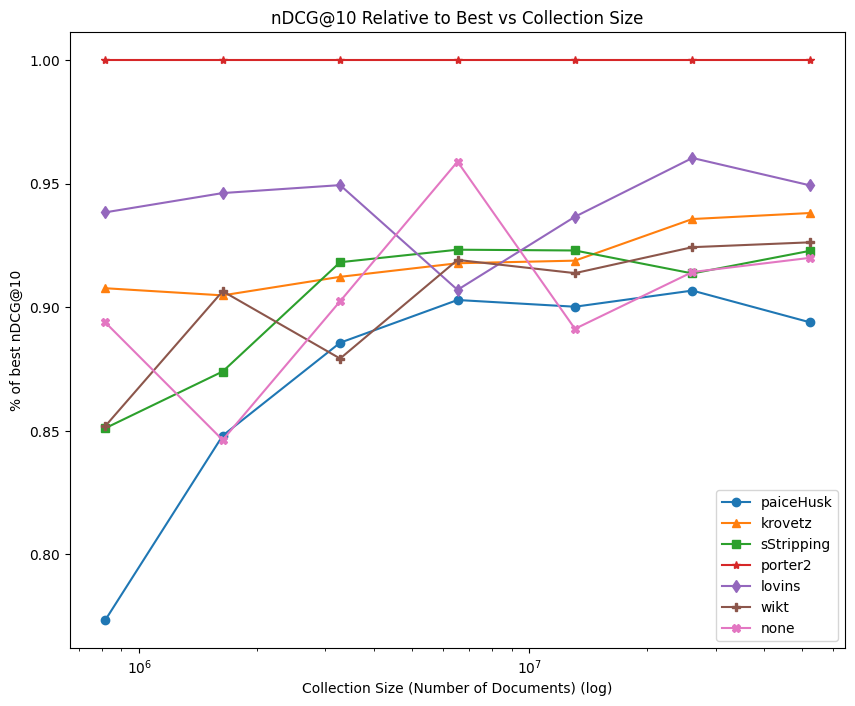

In [8]:
marker = itertools.cycle(MARKERS)

plt.figure(figsize=(10,8))
for stemmer in labels:
    stemmer_data = data_avg[data_avg["stemmer"] == stemmer]
    plt.plot(stemmer_data["collectionSize"], stemmer_data["ndcg"], marker=next(marker), label=stemmer)

plt.title("nDCG@10 vs Collection Size")
plt.xlabel("Collection Size (Number of Documents)")
plt.ylabel("nDCG@10")
plt.legend()

# ----------------------------------------------------------------------

plt.figure(figsize=(10,8))
for stemmer in labels:
    stemmer_data = data_avg[data_avg["stemmer"] == stemmer]
    stemmer_values = np.array(stemmer_data["ndcg"])/best_nDCG
    plt.plot(stemmer_data["collectionSize"], stemmer_values, marker=next(marker), label=stemmer)
    plt.xscale("log")

plt.title("nDCG@10 Relative to Best vs Collection Size")
plt.xlabel("Collection Size (Number of Documents) (log)")
plt.ylabel("% of best nDCG@10")
plt.legend()

### Statistical Significance

In [51]:
#t-test between the porter2 stemmer (one of the best performing) and no stemming
for size in collection_sizes:
    s = list()
    n = list()
    target_data = data[data["collectionSize"] == size]
    s = target_data[target_data["stemmer"] == "porter2"].loc[:,"ndcg"].tolist()
    n = target_data[target_data["stemmer"] == "none"].loc[:,"ndcg"].tolist()
    print(f"Size: {size} {stats.ttest_rel(s,n)}")

Size: 52342886 TtestResult(statistic=2.5028848354969497, pvalue=0.01570228162374955, df=49)
Size: 26171443 TtestResult(statistic=1.833202553623294, pvalue=0.07285092773586502, df=49)
Size: 13085721 TtestResult(statistic=2.257290806907672, pvalue=0.028481586870230245, df=49)
Size: 6542860 TtestResult(statistic=0.9054372437175346, pvalue=0.36966450518863736, df=49)
Size: 3271430 TtestResult(statistic=1.7104286310630306, pvalue=0.09351201001559162, df=49)
Size: 1635715 TtestResult(statistic=1.8107126483338172, pvalue=0.07631860299485718, df=49)
Size: 817857 TtestResult(statistic=1.207551978239582, pvalue=0.23301616307684217, df=49)
Size: 408928 TtestResult(statistic=1.0, pvalue=0.32222340595067556, df=49)
Size: 204464 TtestResult(statistic=-1.0000000000000002, pvalue=0.3222234059506757, df=49)


In [52]:
#t-test between paiceHusk (one of the lowest performing) and none
for size in collection_sizes:
    s = list()
    n = list()
    target_data = data[data["collectionSize"] == size]
    s = target_data[target_data["stemmer"] == "paiceHusk"].loc[:,"ndcg"].tolist()
    n = target_data[target_data["stemmer"] == "none"].loc[:,"ndcg"].tolist()
    print(f"Size: {size} {stats.ttest_rel(s,n)}")

Size: 52342886 TtestResult(statistic=0.6482189875119014, pvalue=0.5198695177418164, df=49)
Size: 26171443 TtestResult(statistic=-0.4318085047545242, pvalue=0.6677747681042917, df=49)
Size: 13085721 TtestResult(statistic=-0.09627543041230226, pvalue=0.9236945136773864, df=49)
Size: 6542860 TtestResult(statistic=-1.0508989536561868, pvalue=0.29846036269961806, df=49)
Size: 3271430 TtestResult(statistic=-0.5663028057790064, pvalue=0.5737726702571546, df=49)
Size: 1635715 TtestResult(statistic=0.25578800957679987, pvalue=0.7991852853132123, df=49)
Size: 817857 TtestResult(statistic=-0.752090776885422, pvalue=0.4555941662047066, df=49)
Size: 408928 TtestResult(statistic=-0.9999999999999999, pvalue=0.32222340595067556, df=49)
Size: 204464 TtestResult(statistic=-1.0000000000000002, pvalue=0.3222234059506757, df=49)


In [53]:
#t-test between porter2 and paiceHusk
for size in collection_sizes:
    s = list()
    n = list()
    target_data = data[data["collectionSize"] == size]
    s = target_data[target_data["stemmer"] == "porter2"].loc[:,"ndcg"].tolist()
    n = target_data[target_data["stemmer"] == "paiceHusk"].loc[:,"ndcg"].tolist()
    print(f"Size: {size} {stats.ttest_rel(s,n)}")

Size: 52342886 TtestResult(statistic=1.5104010371243137, pvalue=0.13736346286541742, df=49)
Size: 26171443 TtestResult(statistic=1.8475032871559378, pvalue=0.07071579035645802, df=49)
Size: 13085721 TtestResult(statistic=2.271904036515404, pvalue=0.027518297851658977, df=49)
Size: 6542860 TtestResult(statistic=1.8017742728088315, pvalue=0.07773482197246549, df=49)
Size: 3271430 TtestResult(statistic=2.1749435224320726, pvalue=0.03448959890574736, df=49)
Size: 1635715 TtestResult(statistic=2.237350776213693, pvalue=0.02984427016874918, df=49)
Size: 817857 TtestResult(statistic=1.4285785528839248, pvalue=0.15946916813248674, df=49)
Size: 408928 TtestResult(statistic=1.413123041417739, pvalue=0.163940683090865, df=49)
Size: 204464 TtestResult(statistic=nan, pvalue=nan, df=49)


In [54]:
#t-test between wikt and none
for size in collection_sizes:
    s = list()
    n = list()
    target_data = data[data["collectionSize"] == size]
    s = target_data[target_data["stemmer"] == "wikt"].loc[:,"ndcg"].tolist()
    n = target_data[target_data["stemmer"] == "none"].loc[:,"ndcg"].tolist()
    print(f"Size: {size} {stats.ttest_rel(s,n)}")

Size: 52342886 TtestResult(statistic=2.642973118345077, pvalue=0.011004263446174601, df=49)
Size: 26171443 TtestResult(statistic=0.8264278998000577, pvalue=0.4125675665843179, df=49)
Size: 13085721 TtestResult(statistic=0.9917411329007888, pvalue=0.32619611418723626, df=49)
Size: 6542860 TtestResult(statistic=-0.049552417613345834, pvalue=0.9606805032908454, df=49)
Size: 3271430 TtestResult(statistic=0.632676551479937, pvalue=0.5298864229562703, df=49)
Size: 1635715 TtestResult(statistic=0.9886959625926465, pvalue=0.3276691590954508, df=49)
Size: 817857 TtestResult(statistic=1.0000000000000002, pvalue=0.3222234059506757, df=49)
Size: 408928 TtestResult(statistic=nan, pvalue=nan, df=49)
Size: 204464 TtestResult(statistic=nan, pvalue=nan, df=49)
